### What is ProCapNet?
Author: Jacob Schreiber \<jmschreiber91@gmail.com\>

#### Introduction

ProCapNet is an extension of the BPNet modeling framework to transcription *initiation*. Note that this is not the same as transcription, which is sometimes directly predicted by other methods, but rather is measured by assays that specifically terminate at the initiation step of transcription. A reason for this is that steady-state transcript abundance is influenced by many factors outside the local genomic window (e.g., presence of other molecules in the cell) and so may not be the best target from sequence-only prediction.

As you might expect, ProCapNet is trained to predict the readout from ProCap experiments. Architecturally, ProCapNet is the same as a BPNet model, but parameter-wise is more similar to a ChromBPNet model, in that it has 512 filters instead of the standard 64. It uses the same number of layers and the same dilation patterns as the other BPNet models.

##### Loading ProCapNet models

Using ProCapNet is almost identical to using a standard BPNet model except with one notable difference: because the ProCapNet codebase is based off an earlier version of bpnet-lite, the trained models are already in torch. This means that you can either use `torch.load` if you have the full model, or the code below if you only have the state dictionary. Make sure that you remember to set the number of control tracks to 0 because those are not used here.

In [1]:
import torch
import tarfile

from io import BytesIO
from bpnetlite import BPNet

with tarfile.open("ENCFF976FHE.tar.gz", "r:gz") as tar:
    model_tar = tar.extractfile("./fold_0/ENCSR261KBX.procapnet_model.fold0.state_dict.torch").read()
    model_state_dict = torch.load(BytesIO(model_tar))

model = BPNet(n_filters=512, n_control_tracks=0).cuda()
model.load_state_dict(model_state_dict)
model

BPNet(
  (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(512, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=512, out_features=

#### Predictions

Now that we have loaded the model into PyTorch, we can use it the same as any other model. Let's investigate predictions at a gene to demonstrate.

In [2]:
import pyfaidx
from tangermeme.utils import one_hot_encode

chrom, mid = "chrX", 73_852_753
start, end = mid - 1057, mid + 1057

X = pyfaidx.Fasta("../../../../common/hg38.fa")[chrom][start:end].seq.upper()
X = one_hot_encode(X)[None].float().cuda()
X.shape

torch.Size([1, 4, 2114])

Just the same as before, we can use the `predict` function to generate logits and log counts. Because ProCapNet makes predictions for a phenomena that is stranded and usually asymetric across strands, you may need to apply the softmax on a reshaped version of the data like below.

In [3]:
from tangermeme.predict import predict

y_logits, y_logcounts = predict(model, X)
y_logits = torch.softmax(y_logits.reshape(1, -1), dim=-1).reshape(*y_logits.shape)

Then we can plot these predictions as before.

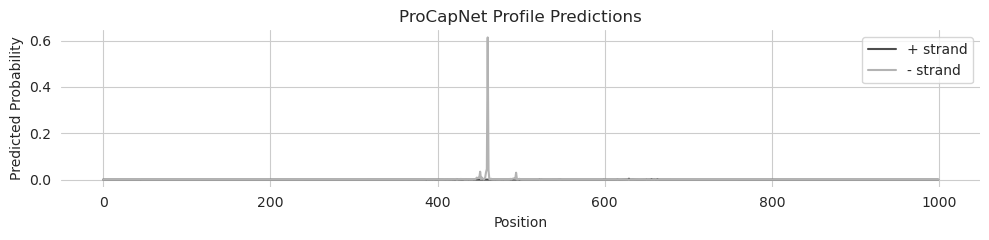

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(10, 2.5))
plt.plot(y_logits[0, 0], c='0.3', label="+ strand")
plt.plot(y_logits[0, 1], c='0.7', label="- strand")

plt.title("ProCapNet Profile Predictions")
plt.ylabel("Predicted Probability")
plt.xlabel("Position")

plt.legend()
plt.tight_layout()
seaborn.despine(bottom=True, left=True)
plt.show()

Unlike the BPNet and ChromBPNet models, the phenomena being predicted by ProCapNet models is much more punctate and spikey. Although there certainly are places where transcription initiation is fuzzier, many genes have high values at an individual basepair like we see here, rather than peaks that can span hundreds of bp.

#### Attributions

Because the model is in PyTorch, just like the other models, we can run attribution methods on ProCapNet just as easily as the other methods. The only consideration here is that the attributions for the profile predictions might become more relevant because the precise positioning of the predicted spikes, and the asymmetry of the strands, may guide the specific features that you look to interpret.

In [5]:
from bpnetlite.bpnet import ProfileWrapper
from bpnetlite.attribute import deep_lift_shap

X_attr = deep_lift_shap(ProfileWrapper(model), X, verbose=True)

/home/jmschrei/github/tangermeme/tangermeme/deep_lift_shap.py:460: RuntimeWarning: Convergence deltas too high: tensor([1.0266e-03, 7.5245e-04, 1.1840e-03, 4.1962e-05, 1.1387e-03, 7.5054e-04,
        9.6321e-05, 7.5865e-04, 1.1668e-03, 1.0285e-03, 1.0390e-03, 7.7343e-04,
        1.1735e-03, 9.5510e-04, 1.2088e-03, 1.1396e-04, 4.5633e-04, 1.0700e-03,
        1.0843e-03, 9.2235e-03], device='cuda:0', grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +
100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.31it/s]


And we can visualize these just as before, with a focus on the nucleotides just under the predicted spike.

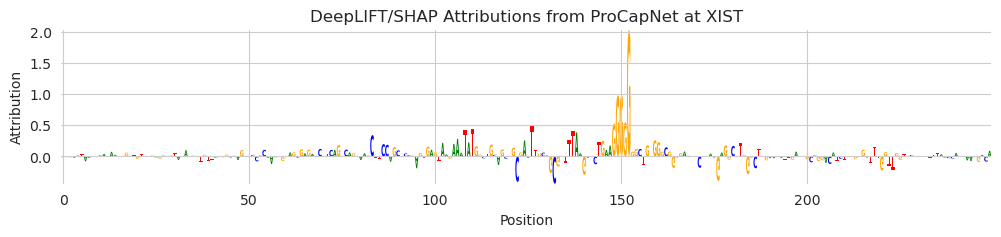

In [6]:
from tangermeme.plot import plot_logo

plt.figure(figsize=(12, 2))
plot_logo(X_attr[0, :, 1057-150:1057+100])
plt.xlabel("Position")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP Attributions from ProCapNet at XIST")
plt.show()

#### Design of a promoter active on a specified strand

A conceptually cool thing you can do with ProCapNets is design transcription initiation in a strand-specific manner. Although in practice, one is likely to want to be careful about which strand to choose and what the downstream implications of such edits might be, in this demonstration we will just do something for fun. Specifically, we will try to flip the strand that is predicted to have transcription initiation in the above example.

To do so, we need to write a simple wrapper that returns some notion of how strong the predictions are on each strand. Remember that ProCapNet only makes predictions as a single number, which is the log count of the total reads across *both* strands, so we cannot use that directly for design. In this wrapper, we just take the logsumexp of the predicted logits in each strand and use that as a notion of how strong each strand is to each other.

In [7]:
from ledidi import ledidi

class StrandWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, X):
        profile, _ = self.model(X)
        profile = torch.logsumexp(profile, dim=-1)
        profile = profile - torch.logsumexp(profile, dim=-1)[:, None]
        return profile

wrapper = StrandWrapper(model)

predict(wrapper, X)

tensor([[-3.3399, -0.0361]])

The predictions showed a spike in the negative strand and here we see that the negative strand (the second value) is much stronger than the positive strand (the first value).

Let's try to flip that and also make it much stronger. We will simultaneously try to make the positive strand more positive and the negative strand much more negative. For speed, and because we want to edit a sequence that we already have, we will use Ledidi to do the design.

In [8]:
y_bar = torch.tensor([[0.0, -8.0]])

X_bar = ledidi(wrapper, X, y_bar, verbose=True)

iter=I	input_loss=0.0	output_loss=37.29	total_loss=37.29	time=0.0
iter=100	input_loss=38.25	output_loss=0.2827	total_loss=4.108	time=2.218
iter=200	input_loss=36.25	output_loss=0.3084	total_loss=3.933	time=1.146
iter=300	input_loss=35.69	output_loss=0.09708	total_loss=3.666	time=1.145
iter=F	input_loss=32.5	output_loss=0.1415	total_loss=3.392	time=5.196


Seems like we were able to flip predicted transcription initiation and get quite close to our goal (low output loss)! And that we actually do not need that many edits to achieve it. Let's confirm that the predictions match what we expected.

In [9]:
predict(wrapper, X_bar)

tensor([[-4.2439e-04, -7.7654e+00],
        [-5.5885e-04, -7.4903e+00],
        [-4.2439e-04, -7.7647e+00],
        [-3.4618e-04, -7.9679e+00],
        [-7.3719e-04, -7.2126e+00],
        [-7.8487e-04, -7.1498e+00],
        [-4.9019e-04, -7.6218e+00],
        [-4.1866e-04, -7.7791e+00],
        [-4.1389e-04, -7.7911e+00],
        [-5.6171e-04, -7.4855e+00],
        [-5.1880e-04, -7.5650e+00],
        [-7.8964e-04, -7.1438e+00],
        [-6.0177e-04, -7.4154e+00],
        [-5.3215e-04, -7.5389e+00],
        [-6.0558e-04, -7.4091e+00],
        [-6.7520e-04, -7.3010e+00]])

Great! Seems like the first column of values are all quite small and near zero, whereas the second column of values are all closer to -8.

We can do a final confirmation that the design worked well by plotting the predicted logits according to the *original model*, and not the wrapped one. This ensures that the wrapper is not doing something weird.

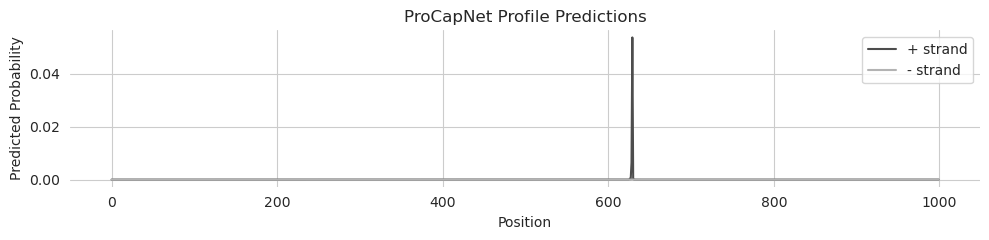

In [10]:
y_logits, y_logcounts = predict(model, X_bar)
y_logits = torch.softmax(y_logits.reshape(1, -1), dim=-1).reshape(*y_logits.shape)

plt.figure(figsize=(10, 2.5))
plt.plot(y_logits[0, 0], c='0.3', label="+ strand")
plt.plot(y_logits[0, 1], c='0.7', label="- strand")

plt.title("ProCapNet Profile Predictions")
plt.ylabel("Predicted Probability")
plt.xlabel("Position")

plt.legend()
plt.tight_layout()
seaborn.despine(bottom=True, left=True)
plt.show()

Perfect. Now we see a sharp spike on the positive strand, and this peak is much sharper than the original predictions on the endogenous sequence.